# Final Model (with dataset 01)

In [1]:
import pandas as pd

df = pd.read_csv('images_3.csv')
df

,image,label
0,ea7b6656-3f84-4eb3-9099-23e623fc1018,Top
1,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,Top
2,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,Shoes
3,5d3a1404-697f-479f-9090-c1ecd0413d27,Bottoms
4,b0c03127-9dfb-4573-8934-1958396937bf,Top
...,...,...
4958,female-casual-peach-color-jeans-female-casual-...,Bottoms
4959,lilac-jeans-wooden-background-lilac-jeans-wood...,Bottoms
4960,jeans-image-table-48097904,Bottoms
4961,jeans-white-background-classical-isolated-clos...,Bottoms


In [2]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
labels = le.fit_transform(df.label)
labels

array([3, 3, 2, ..., 0, 0, 0])

In [3]:
images = df.iloc[:, 0]

## Split data into train and validation using stratified shuffle split

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_index, test_index in ss.split(images, labels):
    train_x, test_x = images[train_index].to_numpy(), images[test_index].to_numpy()
    train_y, test_y = labels[train_index], labels[test_index]

In [5]:
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_index, valid_index in ss.split(train_x, train_y):
    train_x, valid_x = train_x[train_index], train_x[valid_index]
    train_y, valid_y = train_y[train_index], train_y[valid_index]

## Get all images loaded in from sample and convert to tensor

In [6]:
import numpy as np
from skimage.io import imread
from skimage.transform import resize

def get_images(path_list):
    train_img = []
    for filename in path_list:
        path = 'images_compressed/' + filename + '.jpg'
        img = imread(path, as_gray=True)
        img = resize(img, (100, 100))
        img /= 255.0
        img = img.astype('float32')
        train_img.append(img)
    return np.asarray(train_img)

In [8]:
train_x_images = get_images(train_x)

In [9]:
train_x_images.shape

(3176, 100, 100)

In [10]:
valid_x_images = get_images(valid_x)
test_x_images = get_images(test_x)

In [11]:
import torch

train_x_torch = torch.from_numpy(train_x_images).unsqueeze(dim=1)
valid_x_torch = torch.from_numpy(valid_x_images).unsqueeze(dim=1)
test_x_torch = torch.from_numpy(test_x_images).unsqueeze(dim=1)

In [12]:
train_x_torch.shape

torch.Size([3176, 1, 100, 100])

In [13]:
train_y_torch = torch.from_numpy(train_y)
valid_y_torch = torch.from_numpy(valid_y)
test_y_torch = torch.from_numpy(test_y)
train_y_torch.shape

torch.Size([3176])

## Use gpu if available

In [14]:
if torch.cuda.is_available():
    train_x_torch = train_x_torch.cuda()
    train_y_torch = train_y_torch.cuda()
    valid_x_torch = valid_x_torch.cuda()
    valid_y_torch = valid_y_torch.cuda()
    test_x_torch = test_x_torch.cuda()
    test_y_torch = test_y_torch.cuda()
    

In [15]:
train = list(zip(train_x_torch, train_y_torch.to(dtype=torch.long)))
test = list(zip(test_x_torch, test_y_torch.to(dtype=torch.long)))
valid = list(zip(valid_x_torch, valid_y_torch.to(dtype=torch.long)))

In [16]:
# put everything into a data loader because too much data for gpu

from torch.utils.data import DataLoader

trainloader = DataLoader(train, batch_size=16)
testloader = DataLoader(test, batch_size=16)
validloader = DataLoader(valid, batch_size=16)

# Create CNN model

In [17]:
from torch import nn

class ConvNN(nn.Module):
    def __init__(self):
        super(ConvNN, self).__init__()
        
        self.cnn_layers = nn.Sequential (
            # Conv 1
            nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2),   # output = 100 x 100 x 512
            nn.BatchNorm2d(64),                                     
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                   # 50 x 50 x 512
            # Conv 2
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),  
            nn.BatchNorm2d(128),                                     
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                   # 25 X 25 X 512
            # Conv 3
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  
            nn.BatchNorm2d(256),                                     
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                   # 12 X 12 X 512
            # Conv 4
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  
            nn.BatchNorm2d(512),                                     
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                   # 6 X 6 X 512
        )
        
        self.linear_layers = nn.Sequential(
            nn.Linear(512 * 6 * 6, 4)
        )
        
    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [18]:
from torch import optim

model = ConvNN()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

ConvNN(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, 

## Train and collect performance metrics over 100 epochs

In [19]:
train_losses = []
valid_losses = []
ALLOWED_DROPS = 3
drops = ALLOWED_DROPS # how many times would the validation accuracy fall before pulling the plug
train_acc = []
valid_acc = [0]


epochs = 50
for epoch in range(epochs):
    train_loss = 0.
    valid_loss = 0.
    train_correct = 0
    train_total = 0
    valid_correct = 0
    valid_total = 0
    
    model.train()
    for images, labels in trainloader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        for i in range(len(labels)):
            image = images[i].view(1, 1, 100, 100)
            with torch.no_grad():
                logps = model(image)
            allprobs = torch.exp(logps)
            prob = allprobs.tolist()[0]
            hyp = prob.index(max(prob))
            train_y = labels[i]
            train_total += 1
            if train_y.item() == hyp:
                train_correct += 1
                
    train_losses.append(train_loss/len(trainloader))
    
    model.eval()
    for images, labels in validloader:
        output = model(images)
        loss = criterion(output, labels)
        valid_loss += loss.item()
        for i in range(len(labels)):
            image = images[i].view(1, 1, 100, 100)
            with torch.no_grad():
                logps = model(image)
            allprobs = torch.exp(logps)
            prob = allprobs.tolist()[0]
            hyp = prob.index(max(prob))
            valid_y = labels[i]
            valid_total += 1
            if valid_y.item() == hyp:
                valid_correct += 1
                
    valid_losses.append(valid_loss/len(validloader))
    train_acc.append(train_correct/train_total)
    valid_acc.append(valid_correct/valid_total)
    
    print('At epoch', epoch, 'loss =', '%.3g'%(train_loss/len(trainloader)), 'train acc=', '%.3g'%(train_correct/train_total), 'valid loss =', '%.3g'%(valid_loss/len(validloader)), 'valid acc =', '%.3g'%(valid_correct/valid_total))
    
    if valid_acc[-1] <= valid_acc[-2]:
        drops -= 1
        if drops == 0:
            print('Terminating early!')
            break
    else:
        drops = ALLOWED_DROPS

At epoch 0 loss = 0.634 train acc= 0.805 valid loss = 0.592 valid acc = 0.775
At epoch 1 loss = 0.315 train acc= 0.888 valid loss = 0.514 valid acc = 0.805
At epoch 2 loss = 0.192 train acc= 0.921 valid loss = 0.394 valid acc = 0.86
At epoch 3 loss = 0.121 train acc= 0.942 valid loss = 0.406 valid acc = 0.861
At epoch 4 loss = 0.0751 train acc= 0.955 valid loss = 0.434 valid acc = 0.859
At epoch 5 loss = 0.0532 train acc= 0.961 valid loss = 0.462 valid acc = 0.86
At epoch 6 loss = 0.0387 train acc= 0.966 valid loss = 0.479 valid acc = 0.866
At epoch 7 loss = 0.0332 train acc= 0.969 valid loss = 0.431 valid acc = 0.877
At epoch 8 loss = 0.0228 train acc= 0.97 valid loss = 0.402 valid acc = 0.892
At epoch 9 loss = 0.0111 train acc= 0.981 valid loss = 0.394 valid acc = 0.893
At epoch 10 loss = 0.00538 train acc= 0.982 valid loss = 0.396 valid acc = 0.894
At epoch 11 loss = 0.00288 train acc= 0.983 valid loss = 0.406 valid acc = 0.898
At epoch 12 loss = 0.00163 train acc= 0.985 valid loss 

In [20]:
correct = 0.
total = 0.

hyps = []
correct_labels = []

for images, labels in testloader:
    for i in range(len(labels)):
        image = images[i].view(1, 1, 100, 100)
        with torch.no_grad():
            logps = model(image)
        allprobs = torch.exp(logps)
        prob = allprobs.tolist()[0]
        hyp = prob.index(max(prob))
        hyps.append(hyp)
        test_y = labels[i]
        total += 1
        correct_labels.append(test_y.item())
        if test_y.item() == hyp:
            correct += 1

print(correct/total)

0.9103726082578046


## 91% accuracy

In [21]:
from sklearn.metrics import classification_report

print(classification_report(correct_labels, hyps, target_names=['Bottoms', 'Hats', 'Shoes', 'Top']))

              precision    recall  f1-score   support

     Bottoms       0.92      0.83      0.87       252
        Hats       0.79      0.56      0.66        34
       Shoes       0.86      0.78      0.82        87
         Top       0.92      0.98      0.95       620

    accuracy                           0.91       993
   macro avg       0.87      0.79      0.82       993
weighted avg       0.91      0.91      0.91       993



## Examine change in loss/accuracy over time

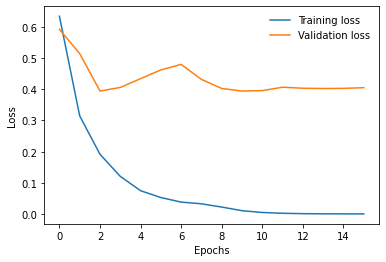

In [23]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

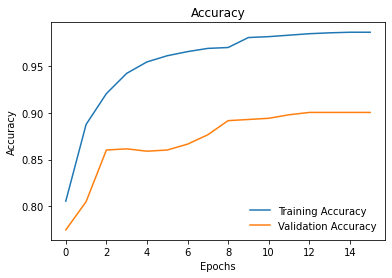

In [28]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc[1:], label='Validation Accuracy')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(frameon=False)

In [25]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(correct_labels, hyps)
cm

array([[209,   2,   6,  35],
       [  1,  19,   2,  12],
       [  9,   1,  68,   9],
       [  7,   2,   3, 608]], dtype=int64)